# Mølmer–Sørensen Gate Simulator
The Molmer-Sorensen Hamiltonian (for one ion) is defined as the sum of the red and blue sideband interactions with symmetric detunning
$$H_{ms}(t) = -i\frac{\eta\Omega}{2}(\sigma_+e^{i\phi_s}-\sigma_-e^{-i\phi_s})(a e^{-i\delta t} + a^{\dagger}e^{i\delta t})$$
However, it is more convinient to use the original form of $\hat{H} = \hat{R}+\hat{B}$, where writes $\delta_r$, $\delta_b$, $\phi_r$, and $\phi_b$ explicitly.
$$-i\frac{\eta}{2}(\Omega_r\sigma_+ae^{-i\delta_r t}e^{i\phi_r}-\Omega_r\sigma_-a^{\dagger}e^{i\delta_r t}e^{-i\phi_r}+ \Omega_b\sigma_+a^{\dagger}e^{-i\delta_b t}e^{i\phi_b} -
\Omega_b\sigma_-ae^{i\delta_b t}e^{-i\phi_b})$$

In [2]:
import qutip as qt
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
from numpy import linalg
#from numpy import *
import pandas as pd
%matplotlib inline

class MSGateExp:
    def __init__(self, Nmax = 10, eta = 0.1):
        self.Nmax = Nmax
        self.eta = eta
        self.omega_r = np.array([1,1]) * np.pi * 2
        self.omega_b = np.array([1,1]) * np.pi * 2
        self.delta_r = np.array([2,2]) * np.pi * 2
        self.delta_b = np.array([-2,-2]) * np.pi * 2
        self.phi_r = 0
        self.phi_b = 0
        self.Gamma = 0 # Heating rate
        self.nth = 0
        self.output = None
    
    def solve(self, t1):
            
        H0 = -1j*self.eta/2 * \
            self.omega_r[0]*np.exp(1j*self.phi_r) * \
            tensor(sigmap(), qeye(2), destroy(self.Nmax))
        def H0_coeff(t, args):
            return np.exp(-1j*self.delta_r[0]*t)
        
        H1 = 1j*self.eta/2 * \
            self.omega_r[0]*np.exp(-1j*self.phi_r) * \
            tensor(sigmam(), qeye(2), create(self.Nmax))
        def H1_coeff(t, args):
            return np.exp(1j*self.delta_r[0]*t)
        
        H2 = -1j*self.eta/2 * \
            self.omega_b[0]*np.exp(1j*self.phi_b) * \
            tensor(sigmap(), qeye(2), create(self.Nmax))
        def H2_coeff(t, args):
            return np.exp(-1j*self.delta_b[0]*t)

        H3 = 1j*self.eta/2 * \
            self.omega_b[0]*np.exp(-1j*self.phi_b) * \
            tensor(sigmam(), qeye(2), destroy(self.Nmax))
        def H3_coeff(t, args):
            return np.exp(1j*self.delta_b[0]*t)

        H4 = -1j*self.eta/2 * \
            self.omega_r[1]*np.exp(1j*self.phi_r) * \
            tensor(qeye(2), sigmap(), destroy(self.Nmax))
        def H4_coeff(t, args):
            return np.exp(-1j*self.delta_r[1]*t)

        H5 = 1j*self.eta/2 * \
            self.omega_r[1]*np.exp(-1j*self.phi_r) * \
            tensor(qeye(2), sigmam(), create(self.Nmax))
        def H5_coeff(t, args):
            return np.exp(1j*self.delta_r[1]*t)

        H6 = -1j*self.eta/2 * \
            self.omega_b[1]*np.exp(1j*self.phi_b) * \
            tensor(qeye(2), sigmap(), create(self.Nmax))
        def H6_coeff(t, args):
            return np.exp(-1j*self.delta_b[1]*t)

        H7 = 1j*self.eta/2 * \
            self.omega_b[1]*np.exp(-1j*self.phi_b) * \
            tensor(qeye(2), sigmam(), destroy(self.Nmax))
        def H7_coeff(t, args):
            return np.exp(1j*self.delta_b[1]*t)
        
        H = [[H0, H0_coeff], [H1, H1_coeff], [H2, H2_coeff], [H3, H3_coeff],
             [H4, H4_coeff], [H5, H5_coeff], [H6, H6_coeff], [H7, H7_coeff]]
        
        Heye = tensor(qeye(2), qeye(2), qeye(self.Nmax))
        
        c_ops = [tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*destroy(self.Nmax)),
                 tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*create(self.Nmax))]
        
        self.output = mesolve(H, self.s_init, t1, c_ops, [])
        
    def time_scan(self,
                 t_start,
                 t_stop,
                 Nsample, 
                 nth = 0.1,
                 Gamma=1/(2.5e3),
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 ):
        self.nth = nth
        self.Gamma = Gamma
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.delta_r = delta_r
        self.delta_b = delta_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        self.s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(self.Nmax, 0.5))
        
        now = datetime.datetime.now()
        t_list = np.linspace(t_start, t_stop, Nsample)
        self.solve(t_list)
        self.measure(self.output.states, t_list)
        now2 = datetime.datetime.now()
        print(now2-now)
        
    
    def StarkShift_scan(self,
                 t_start,
                 t_stop,
                 Nsample,
                 StarkShiftScanList,
                 nth = 0.1,
                 Gamma=0,
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0
                       ):
        self.nth = nth
        self.Gamma = Gamma
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        self.s_init = self.s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(self.Nmax, 0.5))
        
        now = datetime.datetime.now()
        t_list = np.linspace(t_start, t_stop, Nsample)
        ScanResult_ee = []
        ScanResult_gg = []
        
        s_ee = tensor(fock(2, 0), fock(2, 0))
        s_gg = tensor(fock(2, 1), fock(2, 1))
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
            
        for ss in StarkShiftScanList:
            self.delta_r = delta_r + ss
            self.delta_b = delta_b + ss
            
            self.solve(t_list)
            self.measure(self.output.states, t_list)
            ee = _measure(self.output.states[-1], s_ee)
            gg = _measure(self.output.states[-1], s_gg)
            ScanResult_ee.append(ee)
            ScanResult_gg.append(gg)
        now2 = datetime.datetime.now()
        print(now2-now)
        
        plt.plot(StarkShiftScanList, ScanResult_ee, label = '11')
        plt.plot(StarkShiftScanList, ScanResult_gg, label = '00')
        plt.xlabel('Stark Shift scan')
        plt.ylabel('Probability')
        plt.legend()
        
    def detuning_scan(self,
                      delta_start,
                      delta_stop,
                      Nsample,
                      t1=np.linspace(0, 0.5, 2),
                      t2=np.linspace(0, 0.5, 2),
                      nth=0.1,
                      Gamma=1/(2.5e3),
                      omega_r=np.array([1, 1])*np.pi*2,
                      omega_b=np.array([1, 1])*np.pi*2,
                      delta_r=np.array([1, 1])*np.pi*2,
                      delta_b=np.array([-1, -1])*np.pi*2,
                      phi_r=0,
                      phi_b=0
                     ):
        self.nth = nth
        self.Gamma = Gamma
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.delta_r = delta_r
        self.delta_b = delta_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        delta_list = np.linspace(delta_start, delta_stop, Nsample)
        states = []
        for delta in delta_list:
            self.delta_r = delta*np.array([1, 1])*np.pi*2
            self.delta_b = delta*np.array([-1, -1])*np.pi*2
            self.s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(self.Nmax, 0.5))
            self.solve(t1)
            states.append(self.output.states[-1])
        #states = np.array(states)
        self.measure(states, delta_list)
        
    def phase_space_scan(self,
                        t_start,
                        t_stop,
                        Nsample,
                        nth = 0,
                        Gamma = 0.1,
                        omega_r = np.array([1,1]) * np.pi * 2,
                        omega_b = np.array([1,1]) * np.pi * 2,
                        delta_r = np.array([2,2]) * np.pi * 2,
                        delta_b = np.array([-2,-2]) * np.pi * 2,
                        phi_r = 0,
                        phi_b = 0,
                        s_init = None):
        self.nth = nth
        self.Gamma = Gamma
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.delta_r = delta_r
        self.delta_b = delta_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        eigen_states = (tensor(sigmap(), qeye(2)) - tensor(sigmam(), qeye(2)) +
                        tensor(qeye(2), sigmap()) - tensor(qeye(2), sigmam())).eigenstates()
        if not s_init:
            self.s_init = tensor(eigen_states[1][3], fock(self.Nmax, self.nth))
        else:
            self.s_init = s_init
        t_list = np.linspace(t_start, t_stop, Nsample)
        self.solve(t_list)  
        #states = np.array(self.output.states)
        states = self.output.states
        n_phase_plot_x = np.zeros(Nsample)
        n_phase_plot_p = np.zeros(Nsample)
        for i in range(len(states)):
            n_phase_plot_x[i] = self.phase_space_x(states[i])
            n_phase_plot_p[i] = self.phase_space_p(states[i])
        '''
        v_phase_plot_x = np.vectorize(self.phase_space_x)
        v_phase_plot_p = np.vectorize(self.phase_space_p)
        self.plot_ps(v_phase_plot_x(states), v_phase_plot_p(states))
        '''
        self.plot_ps(n_phase_plot_x, n_phase_plot_p)

    def phase_space_x(self, state):
        x = 1/np.sqrt(2)*(destroy(self.Nmax)+create(self.Nmax))
        state_ptr = state.ptrace([2])
        x_expect = np.real((state_ptr*x).tr())
        return x_expect

    def phase_space_p(self, state):
        p = 1j/np.sqrt(2)*(create(self.Nmax)-destroy(self.Nmax))
        state_ptr = state.ptrace([2])
        p_expect = np.real((state_ptr*p).tr())
        return p_expect
    
    
    
    def plot_ps(self, x_array, p_array):
        fig, ax = plt.subplots()
        ax.plot(p_array, x_array)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        ax.grid()
        ax.yaxis.set_ticks(np.arange(-2, 2.5, 0.5))
        ax.xaxis.set_ticks(np.arange(-2, 2.5, 0.5))
        plt.gca().set_aspect('equal', adjustable='box')
        ax.set_xlabel('<x>')
        ax.set_ylabel('<p>')
        plt.show()
        
    
        
    def measure(self, states, x_axis):
        # states: np.array of dm includes two ions and phonons
        s_ee = tensor(fock(2, 0), fock(2, 0))
        s_gg = tensor(fock(2, 1), fock(2, 1))
        s_eg = (tensor(fock(2, 0), fock(2, 1)) +
                tensor(fock(2, 1), fock(2, 0))).unit()
        
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        ee = np.zeros(len(states))
        gg = np.zeros(len(states))
        eg = np.zeros(len(states))
        for i in range(len(states)):
            ee[i] = _measure(states[i], s_ee)
            gg[i] = _measure(states[i], s_gg)
            eg[i] = _measure(states[i], s_eg)
    
        fig, ax = plt.subplots()
        ax.plot(x_axis, ee)
        ax.plot(x_axis, gg)
        ax.plot(x_axis, eg)
        # ax.set_xlabel()
        ax.set_ylabel('Probability')
        ax.legend(('11', '00', '01+10'))
        plt.show()
      
        
        # Plot single ion states:
        '''
        s_e = fock(2, 0)
        s_g = fock(2, 1)
        def _measureSingle0(state, s_meas):
            state_ptr = state.ptrace([0])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        e0 = np.zeros(len(states))
        g0 = np.zeros(len(states))
        for i in range(len(states)):
            e0[i] = _measureSingle0(states[i], s_e)
            g0[i] = _measureSingle0(states[i], s_g)
            
        fig, ax = plt.subplots()
        ax.plot(x_axis, e0)
        ax.plot(x_axis, g0)
        # ax.set_xlabel()
        ax.set_ylabel('Probability of ion0')
        ax.legend(('0', '1'))
        plt.show()
        
        def _measureSingle1(state, s_meas):
            state_ptr = state.ptrace([1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        e1 = np.zeros(len(states))
        g1 = np.zeros(len(states))
        for i in range(len(states)):
            e1[i] = _measureSingle1(states[i], s_e)
            g1[i] = _measureSingle1(states[i], s_g)
            
        fig, ax = plt.subplots()
        ax.plot(x_axis, e1)
        ax.plot(x_axis, g1)
        # ax.set_xlabel()
        ax.set_ylabel('Probability of ion1')
        ax.legend(('0', '1'))
        plt.show()
  '''

Quick gates $\delta_0 = 2 \eta \Omega$, $t_g = 2\pi/\delta_0$

delta =  25000.0
t_gate =  8e-05


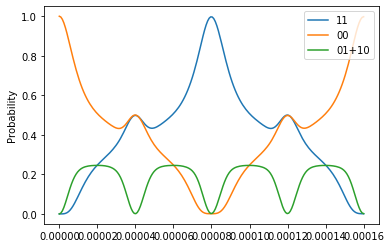

0:00:00.604113


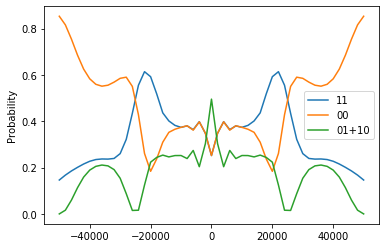

In [77]:
omega = 1.25e5
eta = 0.1
delta = 2*eta*omega
print('delta = ',delta)
tg = 2/delta
tw = 0
print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=10,eta = eta)
# exp1.phase_space_scan(0,1,200)
exp1.time_scan(0, 2*tg, 200, Gamma=0,
               omega_r = np.array([omega,omega]) * np.pi * 2,
               omega_b = np.array([omega,omega]) * np.pi * 2,
               delta_r = np.array([delta,delta]) * np.pi * 2,
               delta_b = np.array([-delta,-delta]) * np.pi * 2)
# exp1.phase_space_scan(0,1,200)
exp1.detuning_scan(-2*delta,2*delta,51,t1=np.linspace(0, tg/2, 2),t2=np.linspace(0, tw, 2),Gamma = 0,
                   omega_r = np.array([omega, omega])*np.pi*2,
                   omega_b = np.array([omega, omega])*np.pi*2)

delta =  1.0


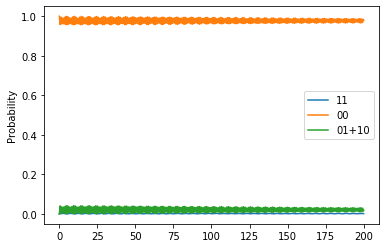

0:00:10.253788


In [82]:
omega = 1
eta = 0.1
delta = 10*eta*omega
print('delta = ',delta)
#tg = 1/delta
#print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=20,eta = eta)
exp1.time_scan(0, 200, 2000, Gamma=0,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([1.1*delta,1.1*delta]) * np.pi * 2,
                 delta_b = np.array([-0.9*delta,-0.9*delta]) * np.pi * 2)

We enlarge the $\delta_0$, $\delta_0 = 20 \eta \Omega$, the t_gate becomes 10 times longer.

delta =  1.5


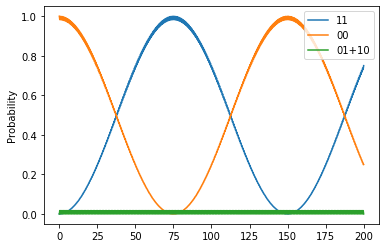

0:00:12.478032


In [78]:
omega = 1
eta = 0.1
delta = 15*eta*omega
print('delta = ',delta)
#tg = 1/delta
#print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=20,eta = eta)
exp1.time_scan(0, 200, 2000, Gamma=0,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2)

delta =  2.0


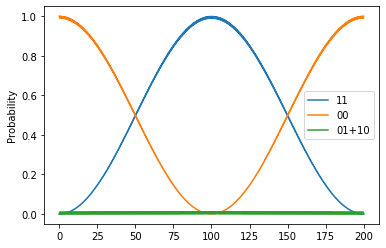

0:00:14.626589


In [79]:
omega = 1
eta = 0.1
delta = 20*eta*omega
print('delta = ',delta)
#tg = 1/delta
#print('t_gate = ', tg)
exp1 = MSGateExp(Nmax=20,eta = eta)
exp1.time_scan(0, 200, 2000, Gamma=0,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2)

# Stark Shift Scan

delta =  2.0


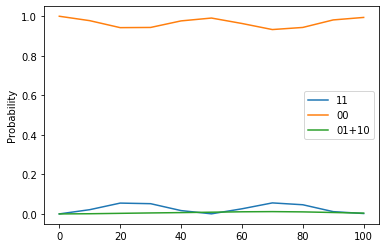

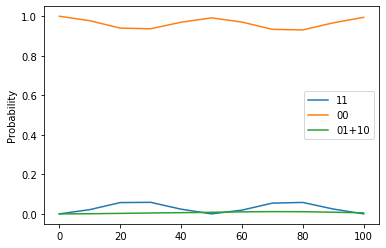

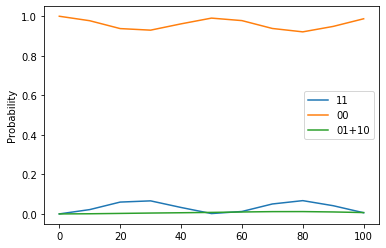

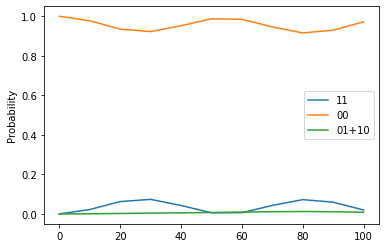

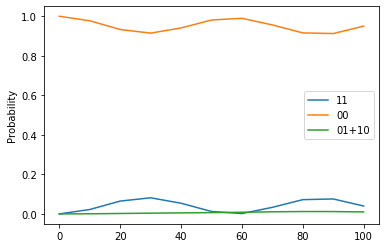

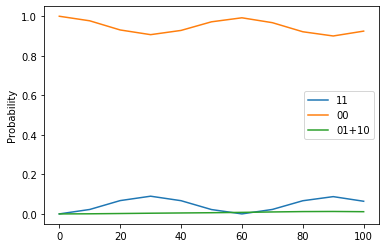

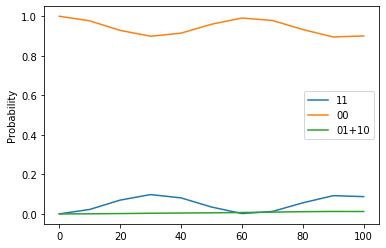

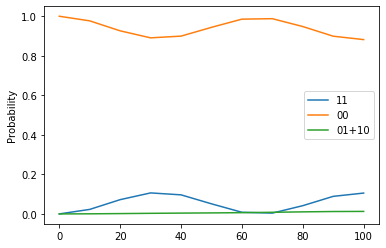

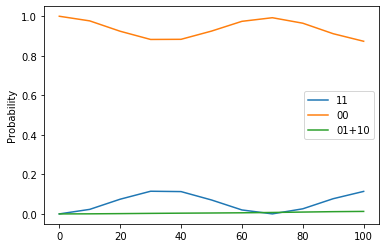

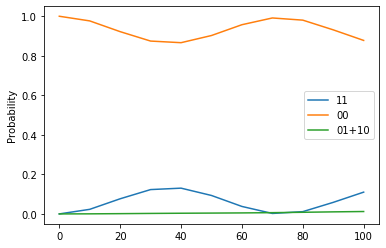

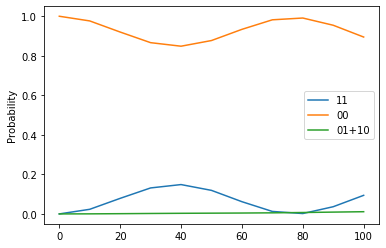

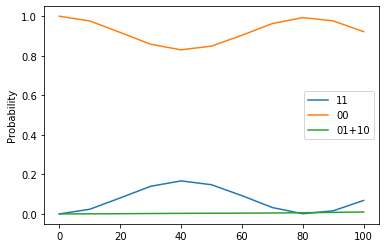

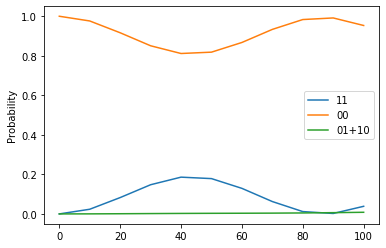

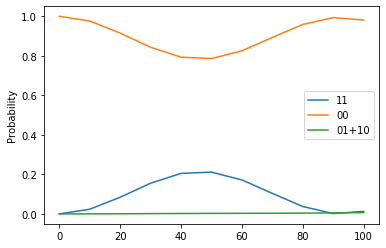

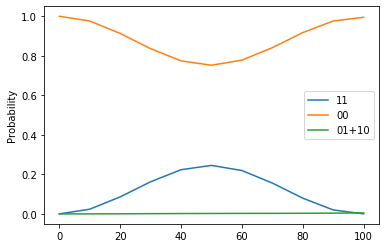

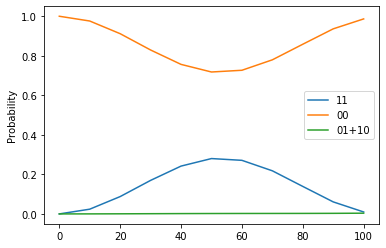

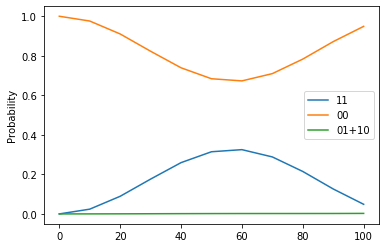

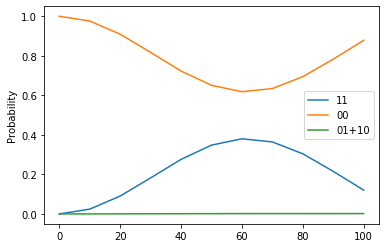

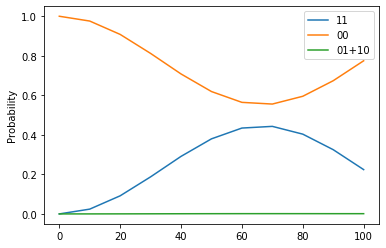

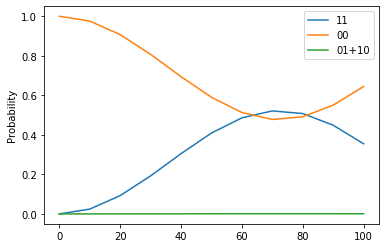

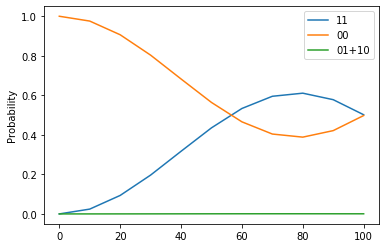

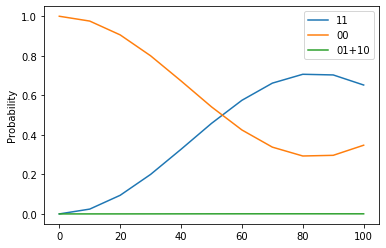

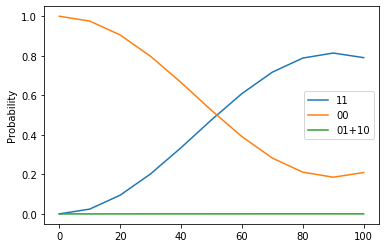

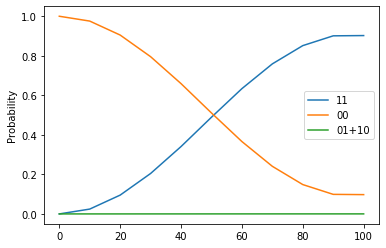

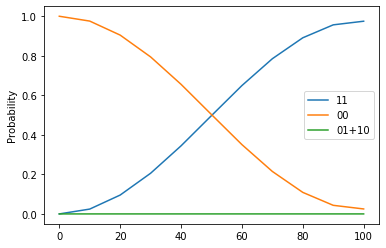

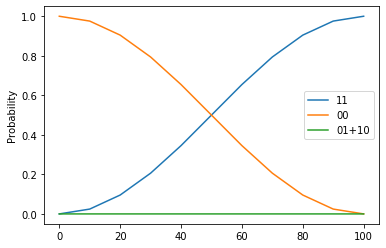

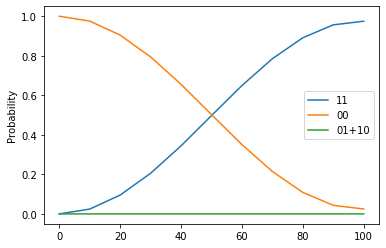

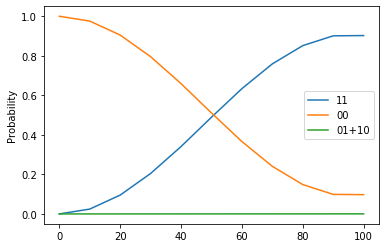

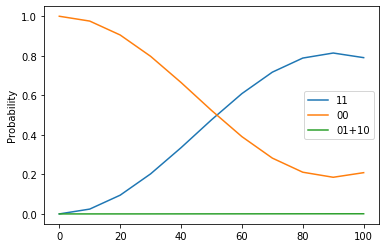

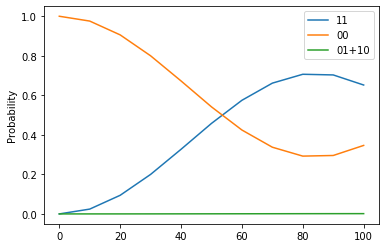

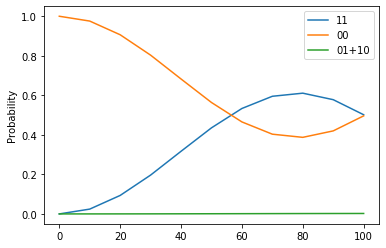

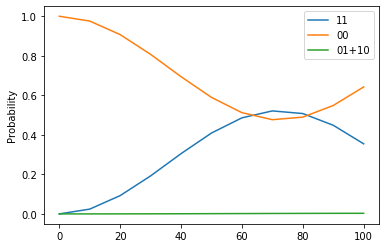

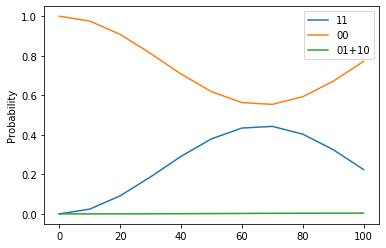

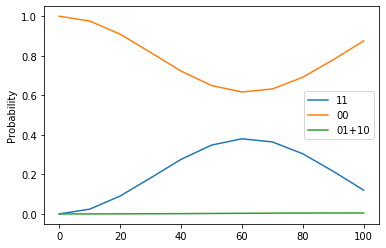

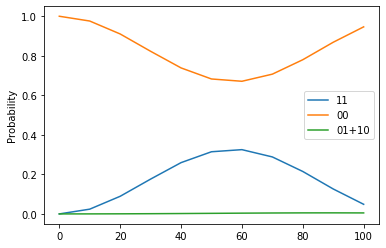

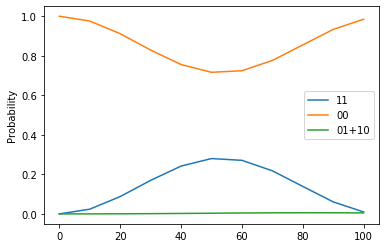

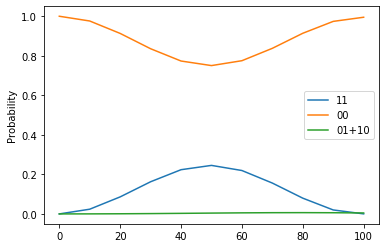

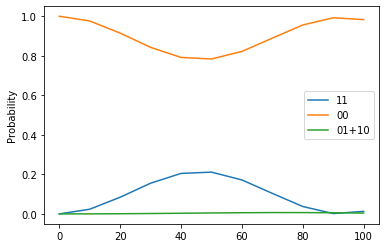

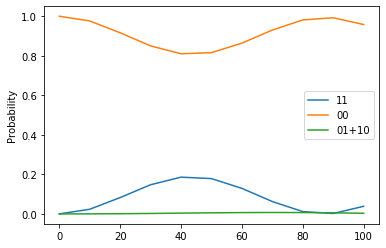

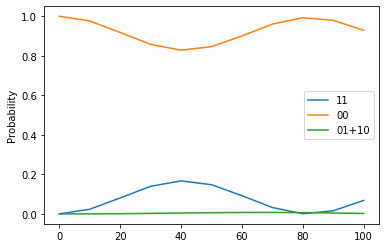

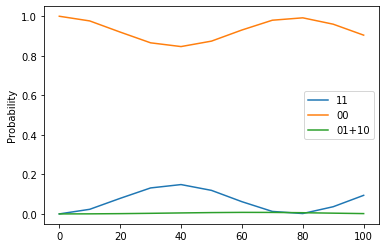

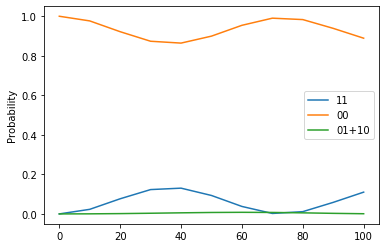

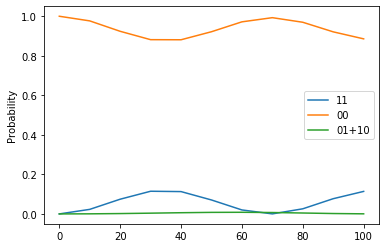

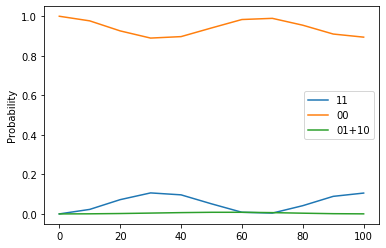

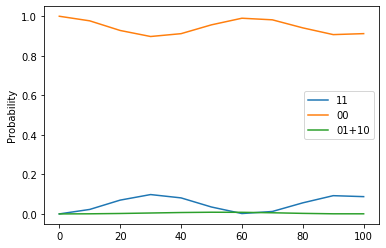

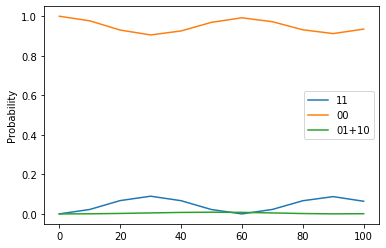

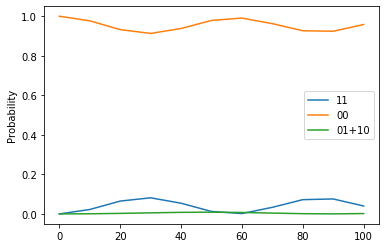

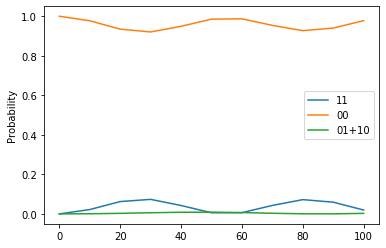

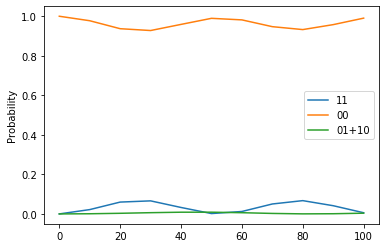

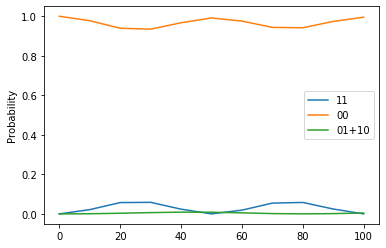

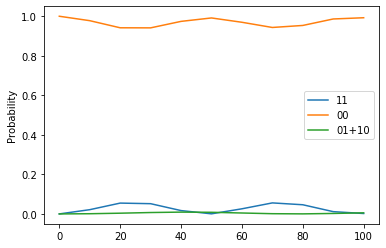

0:05:48.256819


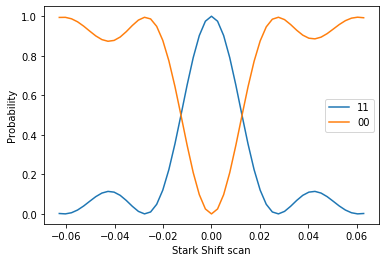

In [3]:
omega = 1
eta = 0.1
delta = 20*eta*omega
print('delta = ',delta)
t_stop = 100
StarkShiftScanList = np.linspace(-2*np.pi*0.01, 2*np.pi*0.01, 51)
exp2 = MSGateExp(Nmax=20,eta = eta)
exp2.StarkShift_scan(
                 t_start = 0,
                 t_stop = t_stop,
                 Nsample = 11,
                 StarkShiftScanList = StarkShiftScanList,
                 nth = 0.1,
                 Gamma=0,
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0)

In [1]:
omega = 1
eta = 0.1
delta = 10*eta*omega
print('delta = ',delta)
t_stop = 50
StarkShiftScanList = np.linspace(-2*np.pi*0.01, 2*np.pi*0.01, 51)
exp2 = MSGateExp(Nmax=20,eta = eta)
exp2.StarkShift_scan(
                 t_start = 0,
                 t_stop = t_stop,
                 Nsample = 11,
                 StarkShiftScanList = StarkShiftScanList,
                 nth = 0.1,
                 Gamma=0,
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0)

delta =  1.0


NameError: name 'np' is not defined

delta =  1.0


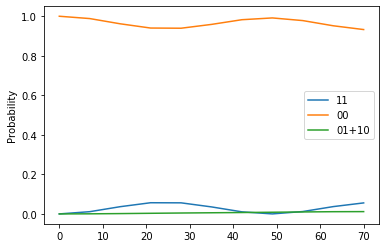

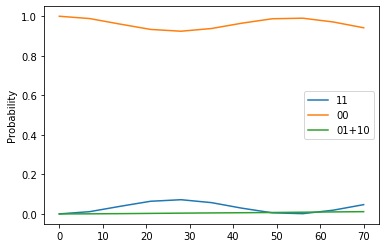

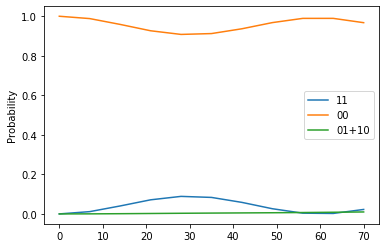

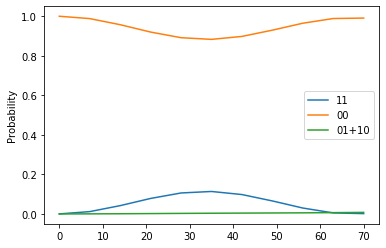

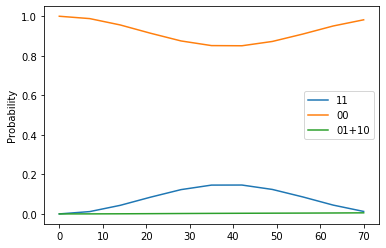

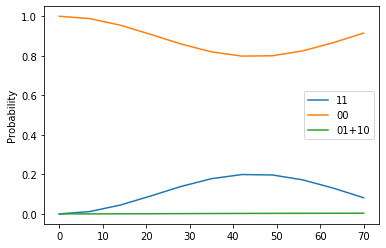

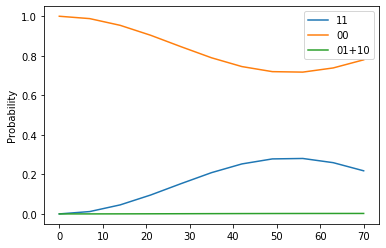

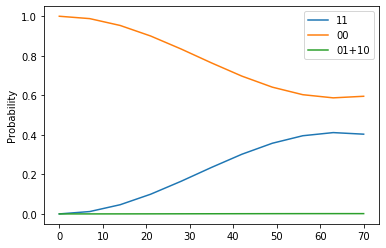

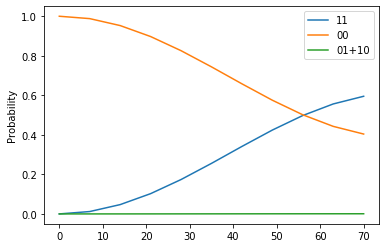

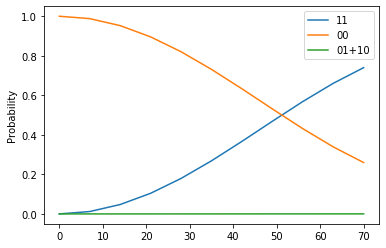

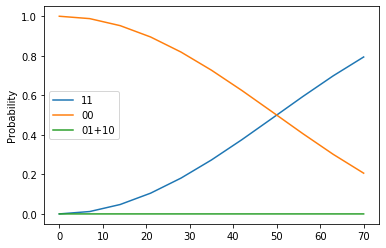

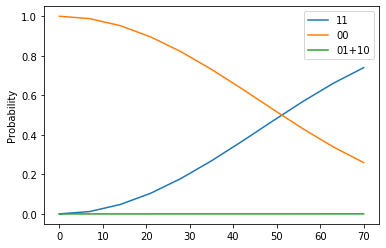

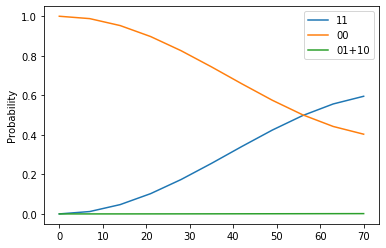

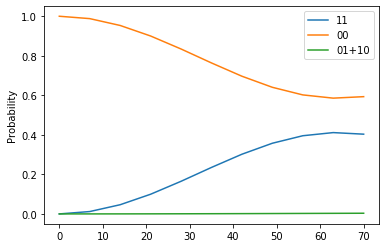

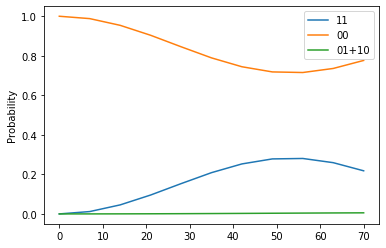

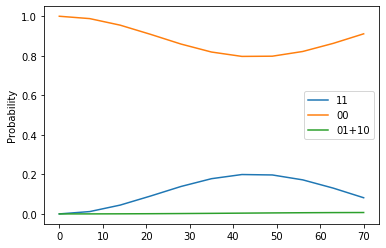

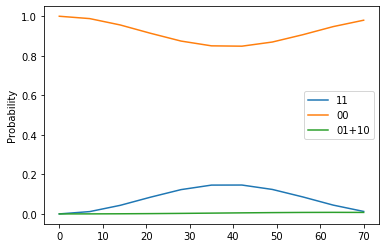

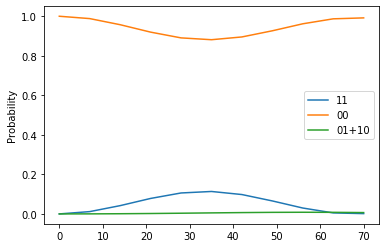

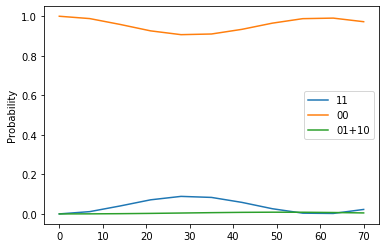

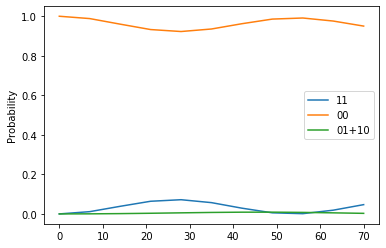

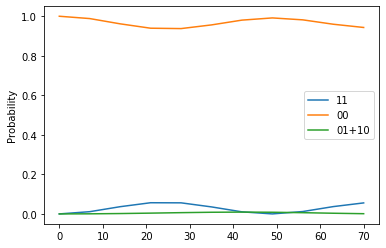

0:01:18.165278


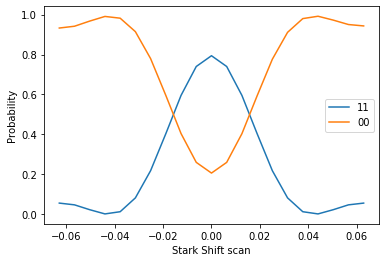

In [83]:
omega = 1
eta = 0.1
delta = 10*eta*omega
print('delta = ',delta)
t_stop = 70
StarkShiftScanList = np.linspace(-2*np.pi*0.01, 2*np.pi*0.01, 21)
exp2 = MSGateExp(Nmax=20,eta = eta)
exp2.StarkShift_scan(
                 t_start = 0,
                 t_stop = t_stop,
                 Nsample = 11,
                 StarkShiftScanList = StarkShiftScanList,
                 nth = 0.1,
                 Gamma=0,
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0)

delta =  1.0


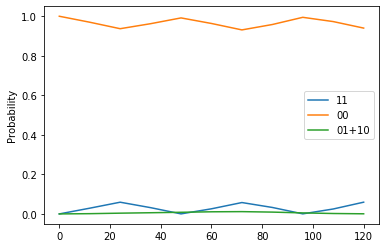

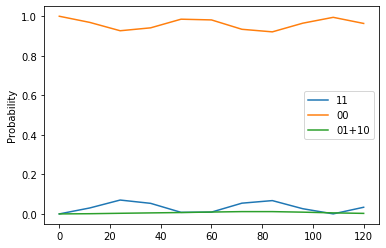

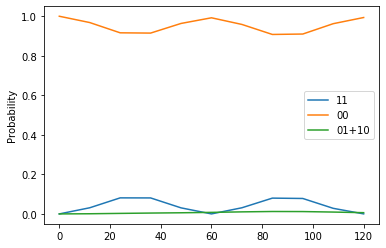

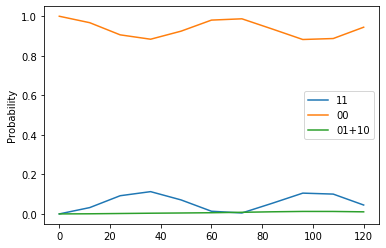

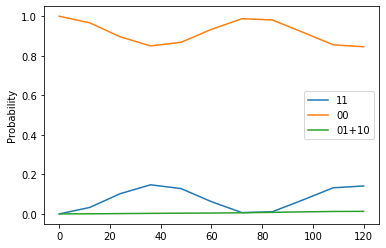

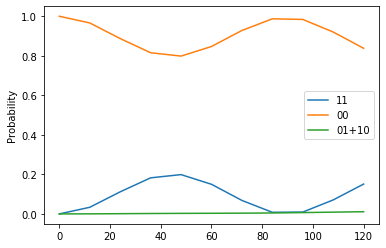

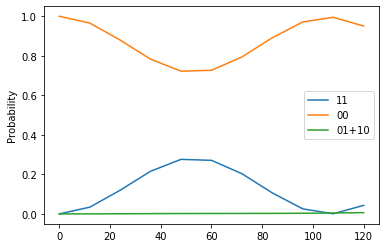

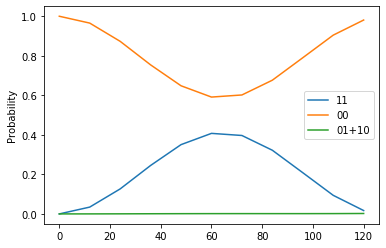

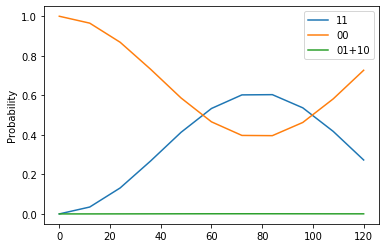

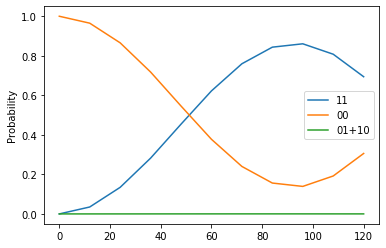

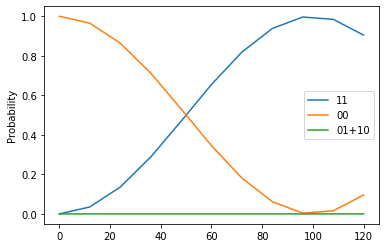

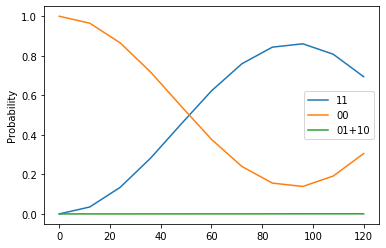

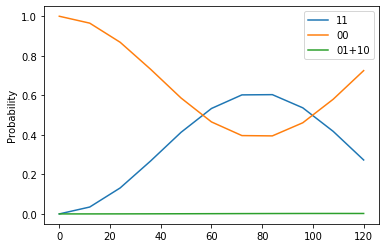

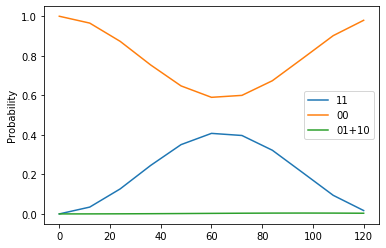

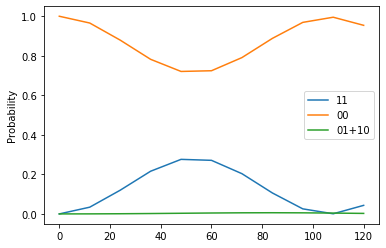

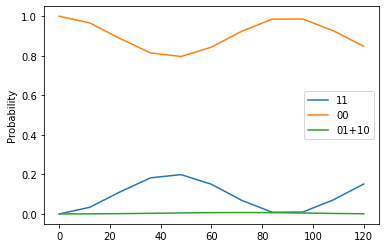

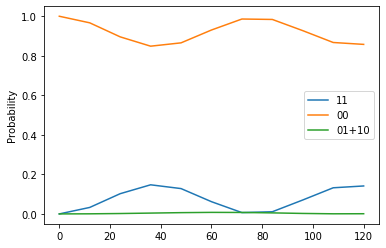

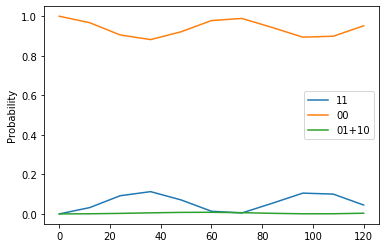

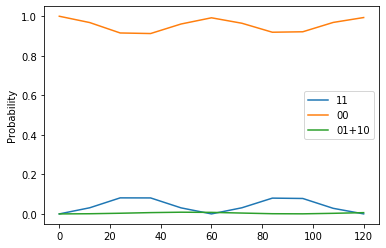

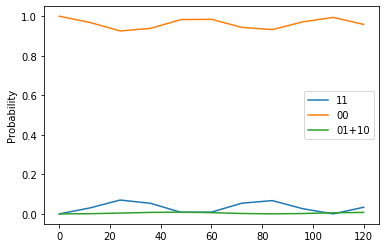

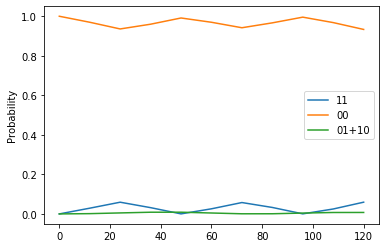

0:02:14.217390


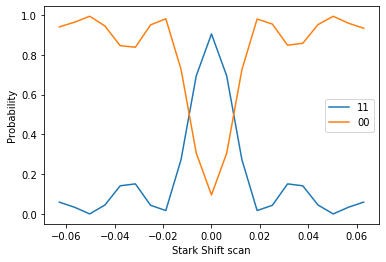

In [84]:
omega = 1
eta = 0.1
delta = 10*eta*omega
print('delta = ',delta)
t_stop = 120
StarkShiftScanList = np.linspace(-2*np.pi*0.01, 2*np.pi*0.01, 21)
exp2 = MSGateExp(Nmax=20,eta = eta)
exp2.StarkShift_scan(
                 t_start = 0,
                 t_stop = t_stop,
                 Nsample = 11,
                 StarkShiftScanList = StarkShiftScanList,
                 nth = 0.1,
                 Gamma=0,
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0)

delta =  1.0


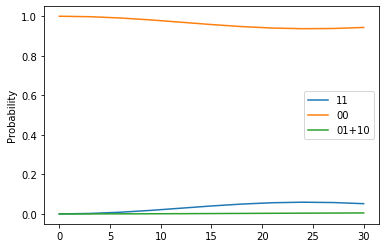

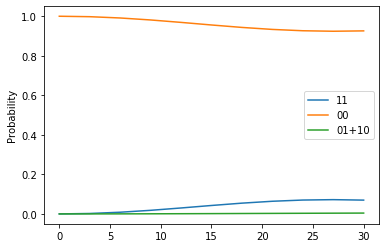

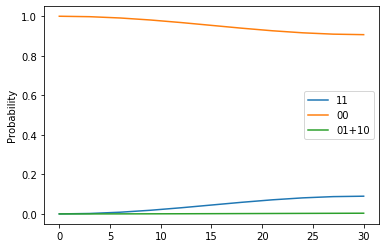

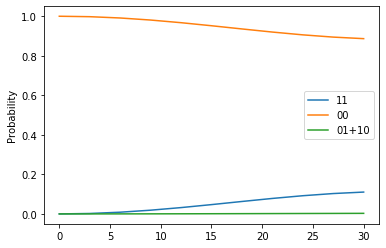

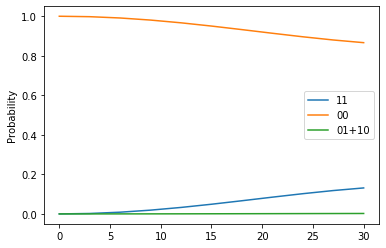

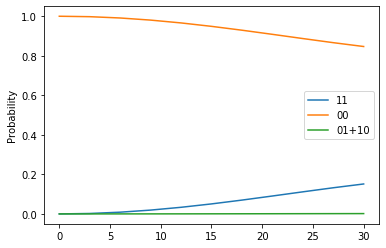

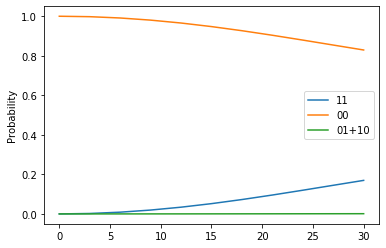

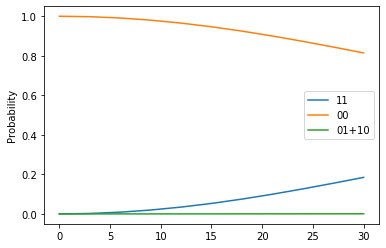

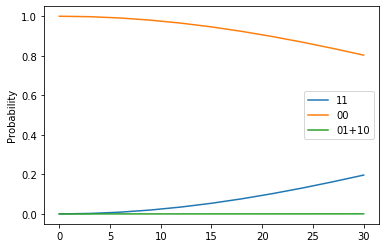

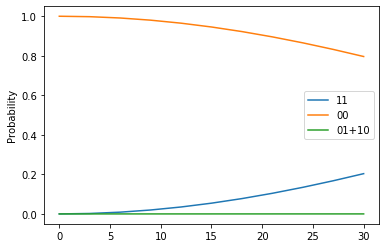

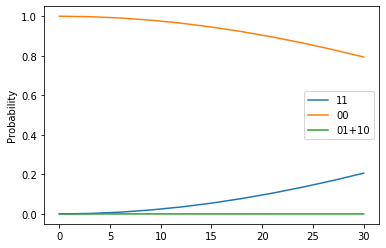

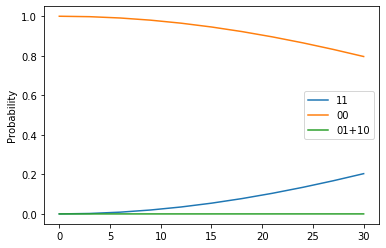

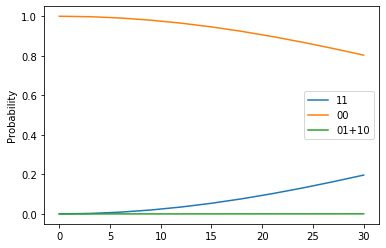

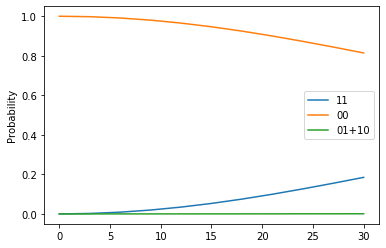

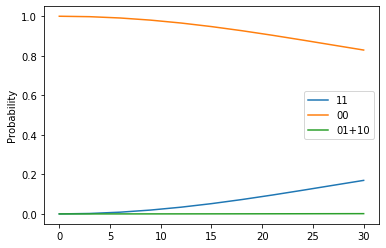

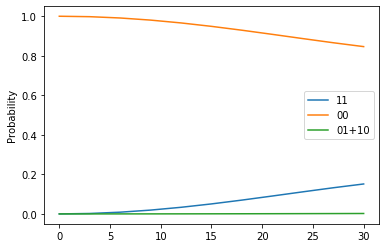

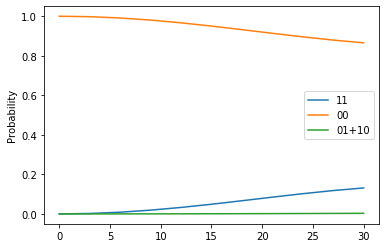

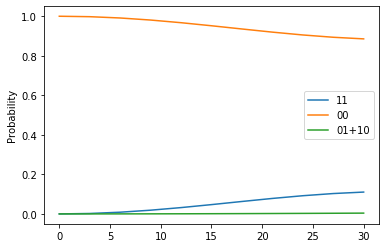

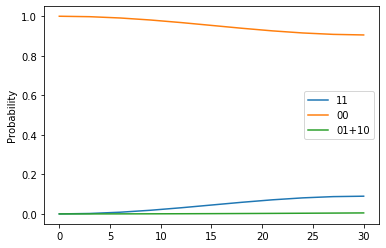

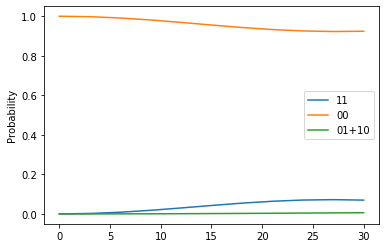

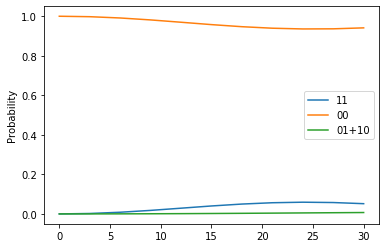

0:01:00.584460


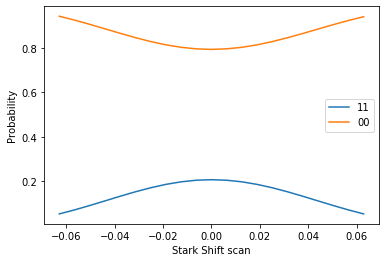

In [85]:
omega = 1
eta = 0.1
delta = 10*eta*omega
print('delta = ',delta)
t_stop = 30
StarkShiftScanList = np.linspace(-2*np.pi*0.01, 2*np.pi*0.01, 21)
exp2 = MSGateExp(Nmax=20,eta = eta)
exp2.StarkShift_scan(
                 t_start = 0,
                 t_stop = t_stop,
                 Nsample = 11,
                 StarkShiftScanList = StarkShiftScanList,
                 nth = 0.1,
                 Gamma=0,
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0)

In [4]:
b = a+a[-1]
b

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ])

In [37]:
omega_b = np.array([1,1]) * np.pi * 2
omega_b + 6.28

array([12.56318531, 12.56318531])